In [ ]:
pip install category_encoders
pip install pdp
from pdpbox import pdp, info_plots
#!pip install pdpbox
import pandas as pd
import seaborn as sns
#from pdpbox.pdp import pdp_isolate, pdp_plot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
#from sklearn.linear_model import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from category_encoders import OneHotEncoder
from category_encoders import OrdinalEncoder
import random
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso


from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Stockx.csv")

Mounted at /content/drive


# Exploring & Playing with the Raw Data


<Axes: xlabel='Sale Price'>

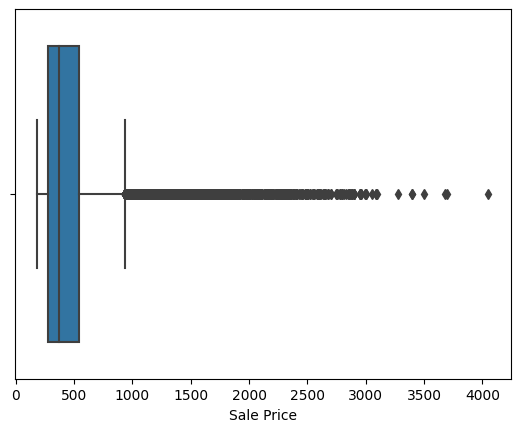

In [ ]:
# Checking for Outliers in Sale Price
import seaborn as sns
sns.boxplot(x=df['Sale Price'])


<Axes: xlabel='Number of Sales'>

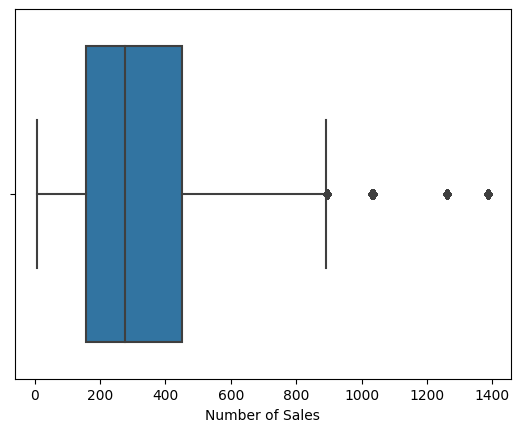

In [ ]:
# Checking for Outliers in Number of Sales
import seaborn as sns
sns.boxplot(x=df['Number of Sales'])


<Axes: >

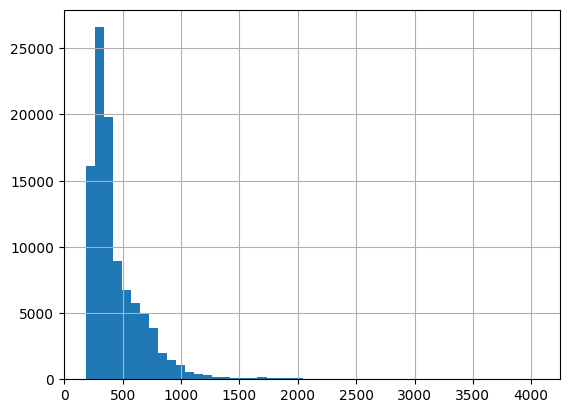

In [ ]:
# Looking at Sale Price Distribution
df['Sale Price'].hist(bins=50)


In [ ]:
# Top 5 Shoes sold?
df.groupby("Sneaker Name")["Sale Price"].count().sort_values(ascending=False)[:15]

Sneaker Name
adidas-Yeezy-Boost-350-V2-Butter                     11423
Adidas-Yeezy-Boost-350-V2-Beluga-2pt0                10395
Adidas-Yeezy-Boost-350-V2-Zebra                      10110
Adidas-Yeezy-Boost-350-V2-Blue-Tint                   9297
Adidas-Yeezy-Boost-350-V2-Cream-White                 9097
Adidas-Yeezy-Boost-350-V2-Sesame                      5553
adidas-Yeezy-Boost-350-V2-Static                      4983
Adidas-Yeezy-Boost-350-V2-Semi-Frozen-Yellow          4854
Air-Jordan-1-Retro-High-Off-White-University-Blue     4635
adidas-Yeezy-Boost-350-V2-Static-Reflective           3184
Nike-Air-Presto-Off-White-Black-2018                  1884
Nike-Air-Presto-Off-White-White-2018                  1883
Nike-Air-VaporMax-Off-White-2018                      1591
Nike-Blazer-Mid-Off-White-All-Hallows-Eve             1435
Nike-Blazer-Mid-Off-White-Grim-Reaper                 1398
Name: Sale Price, dtype: int64

In [ ]:
# Top 5 dates with the most number of transacitons
df.groupby("Order Date")["Sale Price"].count().sort_values(ascending=False)[:20]

Order Date
11-16-2018    1388
11-23-2018    1262
12-27-2018    1034
06-30-2018    1033
02-07-2019     893
12-14-2018     890
02-06-2019     879
11-26-2018     817
12-28-2018     763
12-26-2018     745
11-25-2017     657
12-16-2017     635
12-19-2018     630
01-04-2019     594
10-31-2018     585
01-03-2019     552
05-30-2018     547
11-30-2018     538
01-09-2019     536
12-18-2018     530
Name: Sale Price, dtype: int64

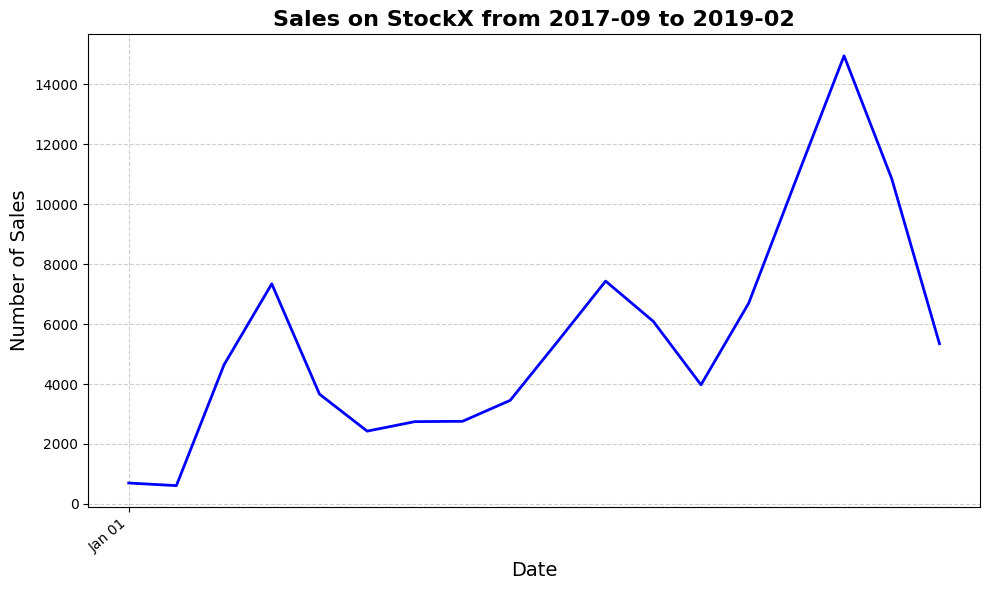

In [ ]:
# Plotting the Number of sales vs. Date on StockX

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Increase figure size
plt.figure(figsize=(10, 6))

# Plot data
plt.plot(transaction, color='blue', linestyle='-', linewidth=2)

# Title and labels
plt.title('Sales on StockX from 2017-09 to 2019-02', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Sales', fontsize=14)

# X-axis date formatting
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# X-axis tick properties
plt.xticks(rotation=40, horizontalalignment='right', fontweight='light', fontsize='medium')

# Gridlines
plt.grid(True, linestyle='--', alpha=0.6)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


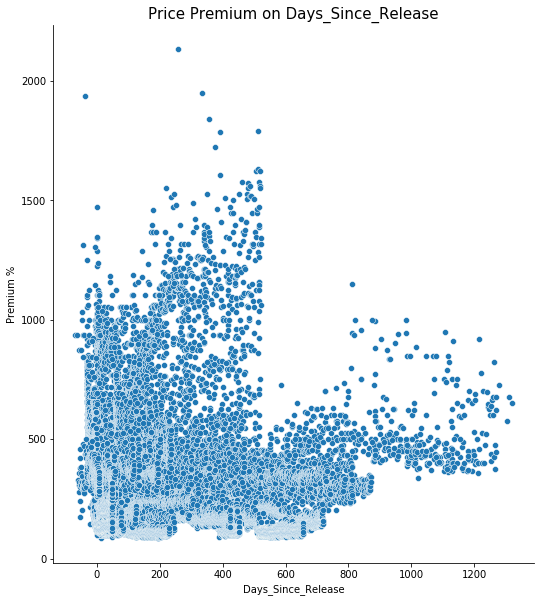

In [ ]:
g = sns.pairplot(df, x_vars=['Days_Since_Release'], y_vars=['Premium %'])
plt.title('Price Premium on Days_Since_Release', fontsize=15)
g.fig.set_size_inches(10,10)
plt.show()


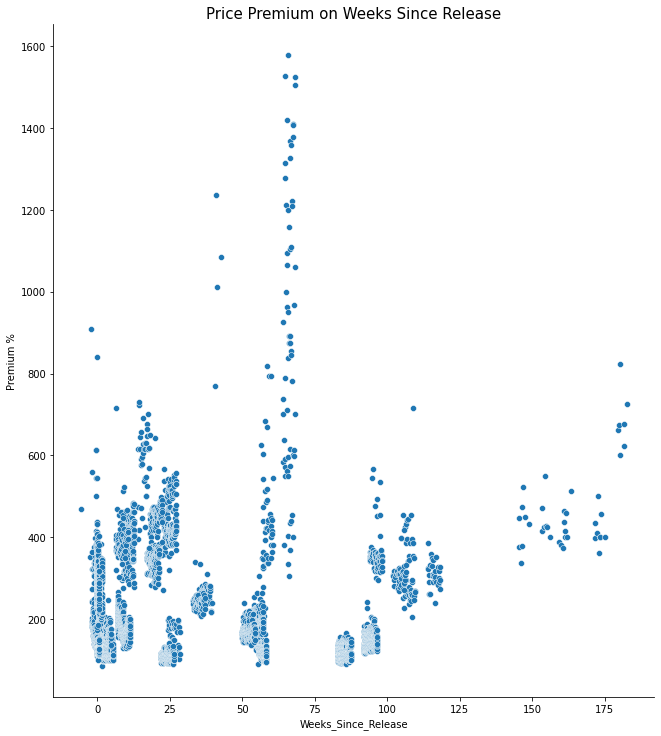

In [ ]:
h = sns.pairplot(df3, x_vars=['Weeks_Since_Release'], y_vars=['Premium %'])
plt.title('Price Premium on Weeks Since Release', fontsize=15)
h.fig.set_size_inches(12.5,12.5)
plt.show()


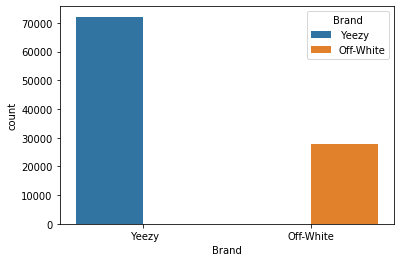

In [ ]:
sns.countplot(x="Brand", hue="Brand", data=df)
plt.show()

# EDA

In [ ]:
import pandas as pd

def load_data(file_path):
    # Load data from a CSV file
    return pd.read_csv(file_path)

def preprocess_dates(df):
    # Convert date columns to the desired format
    df['Order Date'] = pd.to_datetime(df['Order Date']).dt.strftime('%m-%d-%Y')
    df['Release Date'] = pd.to_datetime(df['Release Date']).dt.strftime('%m-%d-%Y')

def create_color_features(df, colors):
    # Initialize and update color columns based on 'Sneaker Name'
    for color in colors:
        df[color] = df['Sneaker Name'].str.contains(color, case=False, na=False).astype(int)

def create_sneaker_features(df, sneaker_types):
    # Extract sneaker type info based on 'Sneaker Name'
    for sneaker, keyword in sneaker_types.items():
        df[sneaker] = df['Sneaker Name'].str.contains(keyword, case=False).astype(int)

def create_region_features(df, states):
    # Extract buyer region info and create corresponding features
    for state in states:
        df[state] = (df['Buyer Region'] == state).astype(int)
    df['Other States'] = (~df['Buyer Region'].isin(states)).astype(int)

def normalize_shoe_size(df):
    # Compute normalized frequency of shoe sizes
    df['size_freq'] = df['Shoe Size'].map(df['Shoe Size'].value_counts(normalize=True))

def convert_retail_sale_price(df):
    # Convert 'Sale Price' from string to float, removing non-numeric characters
    df['Sale Price'] = df['Sale Price'].astype(str).str.replace('$', '').str.replace(',', '').astype(float)
    df['Retail Price'] = df['Retail Price'].replace('[\$,]', '', regex=True).astype(float)
def compute_additional_features(df, color_columns):
    # Compute 'Colorful' and 'Number of Sales' features
    df['Colorful'] = df[color_columns].sum(axis=1)
    df['Number of Sales'] = df['Order Date'].map(df['Order Date'].value_counts())

def drop_unnecessary_columns(df, columns_to_drop):
    # Drop specified columns
    return df.drop(columns=columns_to_drop)

In [ ]:
# Configuration and initial setup
colors = ['Black', 'White', 'Grey', 'Red', 'Green', 'Neon', 'Orange', 'Tan/Brown', 'Pink', 'Blue']
sneaker_types = {
        'yeezy350': 'Yeezy-Boost-350',
        'airjordan': 'Air-Jordan',
        'airforce': 'Air-Force',
        'airmax90': 'Air-Max-90',
        'airmax97': 'Air-Max-97',
        'presto': 'Presto',
        'vapormax': 'Vapormax',
        'blazer': 'Blazer',
        'zoom': 'Zoom',
        'react': 'React'
    }
states = ['California', 'New York', 'Oregon', 'Florida', 'Texas']
columns_to_drop = ['Brand', 'Buyer Region', 'Shoe Size', 'Sneaker Name']

# Data loading and preprocessing
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Stockx.csv")

# Preprocess data (you can check the data anytime by running df.head() in a new cell)
preprocess_dates(df)
convert_retail_sale_price(df)

# Feature creation
create_color_features(df, colors)
create_sneaker_features(df, sneaker_types)
create_region_features(df, states)
normalize_shoe_size(df)

# Additional computations and final adjustments
compute_additional_features(df, colors)  # 'colors' list is reused as 'color_columns'
df = drop_unnecessary_columns(df, columns_to_drop)

# If you need to save the modified DataFrame back to a new CSV file
# df.to_csv('updated_data_file.csv', index=False)

# At this point, you can run df.head() to display the transformed DataFrame
df.head()

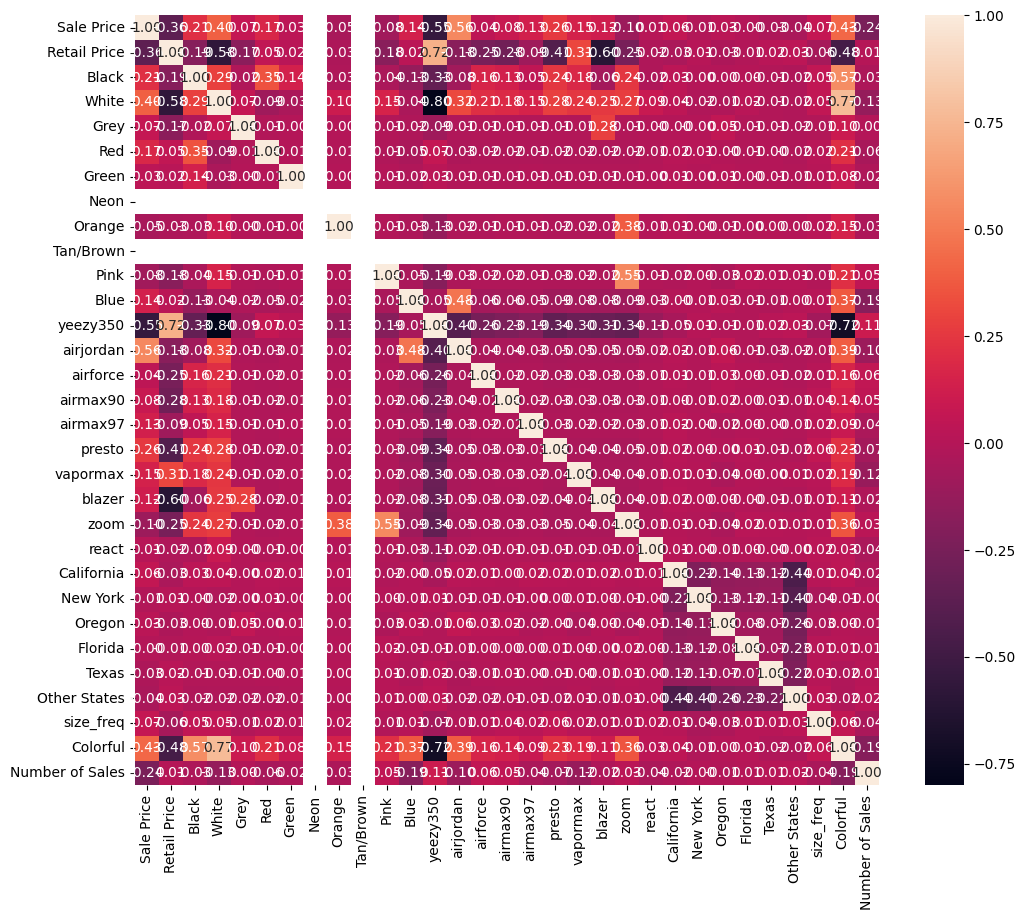

Highly correlated with target: Sale Price    1.000000
yeezy350     -0.545128
airjordan     0.556765
Name: Sale Price, dtype: float64

Highly intercorrelated pairs: Colorful  White       0.774791
White     Colorful    0.774791
dtype: float64


In [ ]:
# Mapping Corrleation

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
corr_matrix = df.corr()

# Plot a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()

# Find features with a high correlation to the target variable
high_corr_with_target = corr_matrix['Sale Price'][corr_matrix['Sale Price'].abs() > 0.5]

# Find pairs of highly intercorrelated features
high_corr_pairs = corr_matrix.unstack().sort_values(kind="quicksort", ascending=False)
high_corr_pairs = high_corr_pairs[(high_corr_pairs > 0.75) & (high_corr_pairs < 1)]

print("Highly correlated with target:", high_corr_with_target)
print("\nHighly intercorrelated pairs:", high_corr_pairs)


# Constructing a Baseline Model

In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming you've loaded your data into 'df' DataFrame and 'Sale Price' is your target variable
# and you already have your train-test split as 'X_train', 'X_test', 'y_train', 'y_test'.

# For the baseline model, we don't need 'X_train' and 'X_test'

# Calculate the mean of the target variable on the training data
mean_sale_price = y_train.mean()

# Create a list where all values are the mean value of 'Sale Price' from the training set, for all examples in the test set
baseline_predictions = [mean_sale_price] * len(y_test)

# Evaluate the baseline model
mae = mean_absolute_error(y_test, baseline_predictions)
mse = mean_squared_error(y_test, baseline_predictions)
r2 = r2_score(y_test, baseline_predictions)

print(f"Baseline Model - Mean Absolute Error (MAE): {mae:.2f}")
print(f"Baseline Model - Mean Squared Error (MSE): {mse:.2f}")
print(f"Baseline Model - R-squared (R2): {r2:.2f}")


Baseline Model - Mean Absolute Error (MAE): 177.05
Baseline Model - Mean Squared Error (MSE): 64669.28
Baseline Model - R-squared (R2): -0.00


# Linear Regression

In [ ]:
import pandas as pd

# 무작위로 훈련/테스트 데이터셋으로 나누기
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_reduced, train_size = 0.80,
                               shuffle=True, random_state=121)

#train = df1.sample(frac=0.75,random_state=1)
#test = df1.drop(train.index)

In [ ]:
target = 'Sale Price'
features = df_reduced.drop(columns=[target]).columns
#features2 = ['Sneaker Name', 'Brand', 'Buyer Region', 'Premium %']

#features = ['Sneaker Name', 'Order Date', 'Release Date', 'Brand', 'Premium', 'Black']
X_train = train[features]
Y_train = train[target]
X_test = test[features]
Y_test = test[target]

In [ ]:
# Create the model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Linear Regression - Mean Absolute Error (MAE): {mae:.2f}")
print(f"Linear Regression - Mean Squared Error (MSE): {mse:.2f}")
print(f"Linear Regression - R-squared (R2): {r2:.2f}")


Linear Regression - Mean Absolute Error (MAE): 86.93
Linear Regression - Mean Squared Error (MSE): 20126.11
Linear Regression - R-squared (R2): 0.69


In [ ]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_absolute_error')
cv_mae = -cv_scores.mean()

print(f"Average MAE from 10-fold cross-validation: {cv_mae:.2f}")


Average MAE from 10-fold cross-validation: 96.04


# Building a Random Forest Model

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor  # or RandomForestClassifier, depending on your target
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame
# Convert 'Retail Price' to numeric values
df['Retail Price'] = df['Retail Price'].replace('[\$,]', '', regex=True).astype(float)

# Convert 'Order Date' and 'Release Date' to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Release Date'] = pd.to_datetime(df['Release Date'])

# You can extract components like the year, month, and day from the date as separate features
df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month
df['Order Day'] = df['Order Date'].dt.day
df['Release Year'] = df['Release Date'].dt.year
df['Release Month'] = df['Release Date'].dt.month
df['Release Day'] = df['Release Date'].dt.day

# Now that we've extracted this information, we can drop the original date columns
df = df.drop(['Order Date', 'Release Date'], axis=1)

# Check for missing values in the DataFrame
if df.isnull().values.any():
    # Handle them, by either dropping or imputing. Here we're dropping for simplicity.
    df = df.dropna()

# Select your target variable
target = 'Sale Price'  # Assuming we are predicting the Sale Price
features = [col for col in df.columns if col != target]  # this selects all other columns

# Create the features matrix (X) and target vector (y)
X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest model
model = RandomForestRegressor(random_state=42)  # or RandomForestClassifier, if your task is classification

# Train the model
model.fit(X_train, y_train)

# Now, your model is trained and you can evaluate it using X_test and y_test or use it to make predictions.


RandomForestRegressor(random_state=42)

In [ ]:
# Make predictions on the test data
predictions = model.predict(X_test)

In [ ]:
from sklearn import metrics

# Calculate the performance metrics
mae = metrics.mean_absolute_error(y_test, predictions)
mse = metrics.mean_squared_error(y_test, predictions)
r2 = metrics.r2_score(y_test, predictions)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")


Mean Absolute Error (MAE): 17.30670909205612
Mean Squared Error (MSE): 1609.5494325848526
R-squared (R2): 0.9751066754518349


In [ ]:
# Get numerical feature importances
importances = list(model.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair))


Variable: airjordan            Importance: 0.31
Variable: Release Day          Importance: 0.21
Variable: Release Year         Importance: 0.07
Variable: yeezy350             Importance: 0.05
Variable: Colorful             Importance: 0.05
Variable: zoom                 Importance: 0.04
Variable: Number of Sales      Importance: 0.04
Variable: Order Year           Importance: 0.04
Variable: Blue                 Importance: 0.03
Variable: size_freq            Importance: 0.03
Variable: Order Month          Importance: 0.03
Variable: presto               Importance: 0.02
Variable: Release Month        Importance: 0.02
Variable: Retail Price         Importance: 0.01
Variable: Black                Importance: 0.01
Variable: airforce             Importance: 0.01
Variable: Order Day            Importance: 0.01
Variable: White                Importance: 0.0
Variable: Grey                 Importance: 0.0
Variable: Red                  Importance: 0.0
Variable: Green                Importance: 

In [ ]:
# Assuming 'df' is your DataFrame and 'features_to_remove' is a list of feature names to remove
features_to_remove = [pair[0] for pair in feature_importances if pair[1] == 0.0]

# Drop these features
df_reduced = df.drop(columns=features_to_remove)

# Retrain your model on this reduced dataframe and evaluate its performance
# ... (retrain and reevaluate your model)


In [ ]:
df_reduced

,Sale Price,Retail Price,Black,Blue,yeezy350,airjordan,airforce,presto,zoom,size_freq,Colorful,Number of Sales,Order Year,Order Month,Order Day,Release Year,Release Month,Release Day
0,1097.0,220.0,0,0,1,0,0,0,0,0.092551,0,23,2017,9,1,2016,9,24
1,685.0,220.0,1,0,1,0,0,0,0,0.092551,1,23,2017,9,1,2016,11,23
2,690.0,220.0,1,0,1,0,0,0,0,0.092551,2,23,2017,9,1,2016,11,23
3,1075.0,220.0,1,0,1,0,0,0,0,0.045040,2,23,2017,9,1,2016,11,23
4,828.0,220.0,1,0,1,0,0,0,0,0.092551,2,23,2017,9,1,2017,2,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99951,565.0,220.0,0,0,1,0,0,0,0,0.053654,0,348,2019,2,13,2018,12,26
99952,598.0,220.0,0,0,1,0,0,0,0,0.053023,0,348,2019,2,13,2018,12,26
99953,605.0,220.0,0,0,1,0,0,0,0,0.026222,0,348,2019,2,13,2018,12,26
99954,650.0,220.0,0,0,1,0,0,0,0,0.092551,0,348,2019,2,13,2018,12,26


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor  # or RandomForestClassifier, depending on your target
from sklearn.model_selection import train_test_split

target = 'Sale Price'  # Assuming we are predicting the Sale Price
features = [col for col in df_reduced.columns if col != target]  # this selects all other columns

# Create the features matrix (X) and target vector (y)
X = df_reduced[features]
y = df_reduced[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest model
model = RandomForestRegressor(random_state=42)  # or RandomForestClassifier, if your task is classification

# Train the model
model.fit(X_train, y_train)

# Now, your model is trained and you can evaluate it using X_test and y_test or use it to make predictions.


RandomForestRegressor(random_state=42)

In [ ]:
# Make predictions on the test data
predictions = model.predict(X_test)

In [ ]:
from sklearn import metrics

# Calculate the performance metrics
mae = metrics.mean_absolute_error(y_test, predictions)
mse = metrics.mean_squared_error(y_test, predictions)
r2 = metrics.r2_score(y_test, predictions)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 17.531389839611624
Mean Squared Error (MSE): 1732.023043684662
R-squared (R2): 0.9732124960697224


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Assuming your data is already preprocessed and split into features (X) and target (y)
# X = your features
# y = your target variable (e.g., Sale Price)

# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=42) # or your chosen parameters

# Perform k-fold cross-validation (let's assume k=10 here)
cv_scores = cross_val_score(rf, X, y, cv=10, scoring='neg_mean_absolute_error') # using MAE as the performance metric

# The 'scoring' parameter can also use other metrics like 'neg_mean_squared_error' for MSE,
# or 'r2' for the R^2 score, depending on what you prefer.

# Since our scores are negative (due to the 'neg_' prefix in the scoring parameter),
# we will invert them to get positive scores.
cv_scores_positive = -cv_scores

# Calculate the average of all k scores to get a single estimation of performance
mean_cv_score = np.mean(cv_scores_positive)

print(f'Average MAE from 10-fold cross-validation: {mean_cv_score:.2f}')


Average MAE from 10-fold cross-validation: 64.26


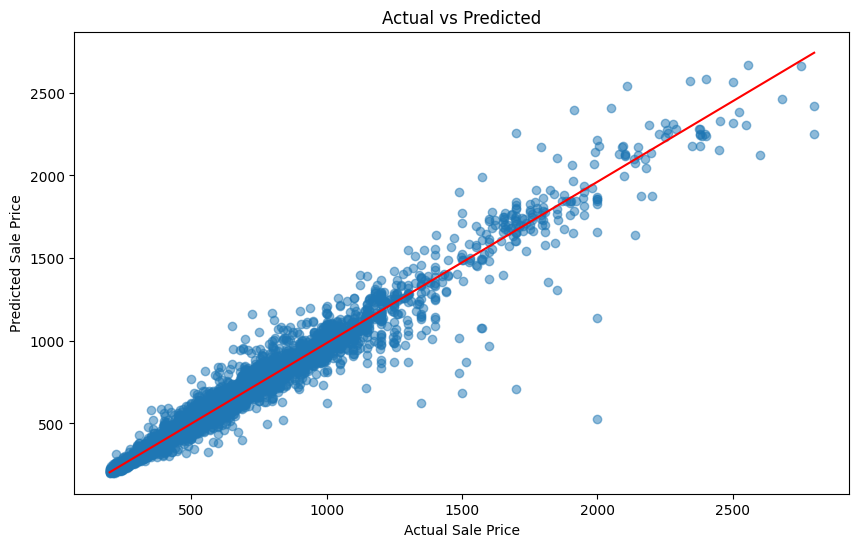

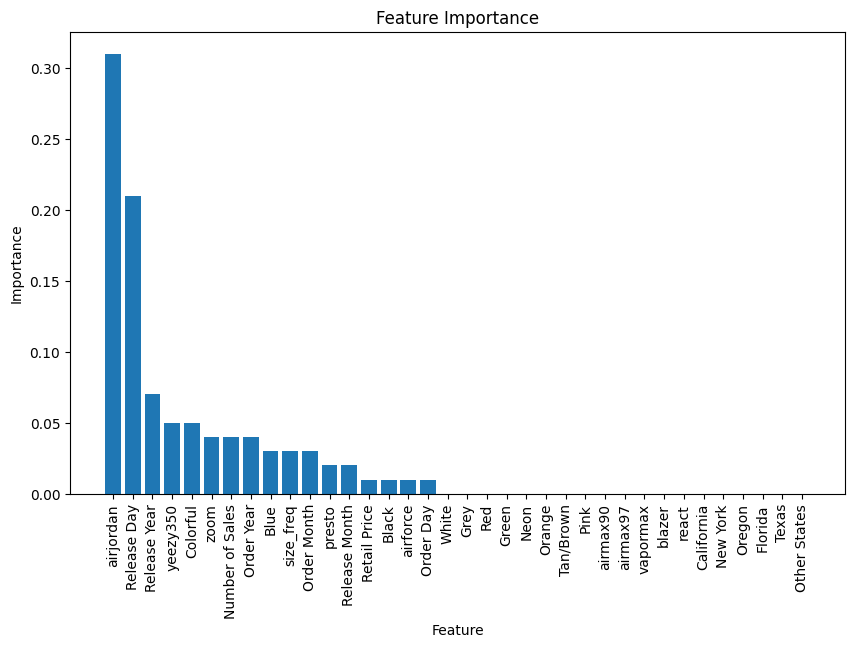

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Visualizing our predictions vs the actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, predictions, 1))(np.unique(y_test)), color='red') # this line represents a simple linear regression line fitted to the predictions
plt.title('Actual vs Predicted')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.show()

# Visualize feature importances
features, importances = zip(*feature_importances)  # unzip the pairs into two lists
plt.figure(figsize=(10, 6))
plt.bar(features, importances, orientation = 'vertical')
plt.xticks(rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importance')
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Assuming your data is already preprocessed and split into features (X) and target (y)
# X = your features
# y = your target variable (e.g., Sale Price)

# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=42) # or your chosen parameters

# Perform k-fold cross-validation (let's assume k=10 here)
cv_scores = cross_val_score(rf, X, y, cv=10, scoring='neg_mean_absolute_error') # using MAE as the performance metric

# The 'scoring' parameter can also use other metrics like 'neg_mean_squared_error' for MSE,
# or 'r2' for the R^2 score, depending on what you prefer.

# Since our scores are negative (due to the 'neg_' prefix in the scoring parameter),
# we will invert them to get positive scores.
cv_scores_positive = -cv_scores

# Calculate the average of all k scores to get a single estimation of performance
mean_cv_score = np.mean(cv_scores_positive)

print(f'Average MAE from 10-fold cross-validation: {mean_cv_score:.2f}')


Average MAE from 10-fold cross-validation: 63.76


# XG Boost

In [ ]:
pip install xgboost


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Specify parameters via map
params = {'max_depth': 3, 'eta': 0.1, 'objective': 'reg:squarederror'}
num_round = 100  # the number of training iterations

# Training the model
bst = xgb.train(params, dtrain, num_round)

# Making predictions
predictions = bst.predict(dtest)

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"XGBoost - Mean Absolute Error (MAE): {mae:.2f}")
print(f"XGBoost - Mean Squared Error (MSE): {mse:.2f}")
print(f"XGBoost - R-squared (R2): {r2:.2f}")


XGBoost - Mean Absolute Error (MAE): 51.95
XGBoost - Mean Squared Error (MSE): 8508.40
XGBoost - R-squared (R2): 0.87


In [ ]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define the number of folds for cross-validation
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize lists to store the results of cross-validation
cv_mae_scores = []
cv_mse_scores = []
cv_r2_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets for this fold
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

    # Create DMatrix for XGBoost
    dtrain_cv = xgb.DMatrix(X_train_cv, label=y_train_cv)
    dtest_cv = xgb.DMatrix(X_test_cv, label=y_test_cv)

    # Training the model
    bst_cv = xgb.train(params, dtrain_cv, num_round)

    # Making predictions
    predictions_cv = bst_cv.predict(dtest_cv)

    # Evaluate the model
    cv_mae_scores.append(mean_absolute_error(y_test_cv, predictions_cv))
    cv_mse_scores.append(mean_squared_error(y_test_cv, predictions_cv))
    cv_r2_scores.append(r2_score(y_test_cv, predictions_cv))

# Calculate and print the average error metrics across all folds
print(f"XGBoost - Mean Absolute Error (MAE) - CV: {np.mean(cv_mae_scores):.2f}")
print(f"XGBoost - Mean Squared Error (MSE) - CV: {np.mean(cv_mse_scores):.2f}")
print(f"XGBoost - R-squared (R2) - CV: {np.mean(cv_r2_scores):.2f}")


XGBoost - Mean Absolute Error (MAE) - CV: 51.63
XGBoost - Mean Squared Error (MSE) - CV: 7768.10
XGBoost - R-squared (R2) - CV: 0.88


# LightGBM

In [ ]:
pip install lightgbm


In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Create and train the model
gbm = lgb.LGBMRegressor(boosting_type='gbdt',
                        objective='regression',
                        num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=100,
                        feature_fraction=0.9,
                        bagging_fraction=0.8,
                        bagging_freq=5)

# Fit the model
# Note: We're not specifying 'early_stopping_rounds' here
gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='l1')

# Predict
predictions = gbm.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"LightGBM - Mean Absolute Error (MAE): {mae:.2f}")
print(f"LightGBM - Mean Squared Error (MSE): {mse:.2f}")
print(f"LightGBM - R-squared (R2): {r2:.2f}")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tru

In [ ]:
# Assuming X and y are your features and target variable
mae_scores = cross_val_score(gbm, X, y, scoring='neg_mean_absolute_error', cv=10)

# Convert scores to positive MAE scores
mae_scores = -mae_scores

print(f"MAE scores for each fold are: {mae_scores}")
print(f"Average MAE from 10-fold cross-validation: {np.mean(mae_scores):.2f}")
print(f"Standard Deviation in MAE from 10-fold cross-validation: {np.std(mae_scores):.2f}")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tru

# Ensemble Model

In [ ]:
import xgboost as xgb

# Convert X_test to DMatrix for XGBoost
dtest_xgb = xgb.DMatrix(X_test)

# Predictions from the individual models
predictions_rf = model.predict(X_test)
predictions_xgb = bst.predict(dtest_xgb)
predictions_lgbm = gbm.predict(X_test)

# Averaging the predictions
average_predictions = (predictions_rf + predictions_xgb + predictions_lgbm) / 3

# Evaluate the ensemble model
ensemble_mae = mean_absolute_error(y_test, average_predictions)
ensemble_mse = mean_squared_error(y_test, average_predictions)
ensemble_r2 = r2_score(y_test, average_predictions)

print(f"Ensemble - Mean Absolute Error (MAE): {ensemble_mae:.2f}")
print(f"Ensemble - Mean Squared Error (MSE): {ensemble_mse:.2f}")
print(f"Ensemble - R-squared (R2): {ensemble_r2:.2f}")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Ensemble - Mean Absolute Error (MAE): 31.90
Ensemble - Mean Squared Error (MSE): 3281.18
Ensemble - R-squared (R2): 0.95


In [ ]:
X_test

,Retail Price,Black,Blue,yeezy350,airjordan,airforce,presto,zoom,size_freq,Colorful,Number of Sales,Order Year,Order Month,Order Day,Release Year,Release Month,Release Day
28,220.0,0,0,1,0,0,0,0,0.087879,1,15,2017,9,2,2017,4,29
55,220.0,1,0,1,0,0,0,0,0.087879,2,17,2017,9,4,2017,2,11
60,220.0,0,0,1,0,0,0,0,0.086888,1,17,2017,9,4,2017,4,29
66,220.0,0,0,1,0,0,0,0,0.053023,0,17,2017,9,4,2017,2,25
74,220.0,1,0,1,0,0,0,0,0.092551,2,22,2017,9,5,2017,2,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99907,220.0,0,0,1,0,0,0,0,0.086888,0,348,2019,2,13,2018,12,27
99918,220.0,0,0,1,0,0,0,0,0.040148,0,348,2019,2,13,2018,12,27
99935,220.0,0,0,1,0,0,0,0,0.046040,0,348,2019,2,13,2018,12,27
99938,220.0,0,0,1,0,0,0,0,0.035786,0,348,2019,2,13,2018,12,27


In [ ]:
predictions_rf

array([471.30178571, 766.96      , 476.95595238, ..., 276.2695    ,
       350.70066667, 592.11947619])

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import numpy as np

kf = KFold(n_splits=10, random_state=42, shuffle=True)
mae_scores = []


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

kf = KFold(n_splits=10, random_state=42, shuffle=True)
mae_scores = []

for train_index, test_index in kf.split(X):
    # Splitting the data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Training Random Forest
    model_rf = RandomForestRegressor(random_state=42)
    model_rf.fit(X_train, y_train)

    # Training XGBoost
    model_xgb = xgb.XGBRegressor(random_state=42)
    model_xgb.fit(X_train, y_train)

    # Training LightGBM
    model_lgbm = lgb.LGBMRegressor(random_state=42)
    model_lgbm.fit(X_train, y_train)

    # Making predictions
    predictions_rf = model_rf.predict(X_test)
    predictions_xgb = model_xgb.predict(X_test)
    predictions_lgbm = model_lgbm.predict(X_test)

    # Averaging the predictions for the ensemble
    ensemble_predictions = (predictions_rf + predictions_xgb + predictions_lgbm) / 3

    # Calculating MAE for this fold
    fold_mae = mean_absolute_error(y_test, ensemble_predictions)
    mae_scores.append(fold_mae)

average_mae = np.mean(mae_scores)
print(f"Average MAE from 10-fold cross-validation: {average_mae:.2f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 89960, number of used features: 17
[LightGBM] [Info] Start training from score 446.124944
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 89960, number of used features: 17
[LightGBM] [Info] Start training from score 446.543942
[LightGBM] [Warning] Found

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'X' and 'y' are your full dataset and labels
# Splitting the data - 80% for training and cross-validation, 20% for hold-out testing
X_train_cv, X_holdout, y_train_cv, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Assuming you have a hold-out test set: X_holdout, y_holdout

# Make predictions with each model
predictions_rf = model_rf.predict(X_holdout)
predictions_xgb = model_xgb.predict(X_holdout)
predictions_lgbm = model_lgbm.predict(X_holdout)

# Average the predictions
ensemble_predictions = (predictions_rf + predictions_xgb + predictions_lgbm) / 3

# Evaluate the ensemble model
mae = mean_absolute_error(y_holdout, ensemble_predictions)
mse = mean_squared_error(y_holdout, ensemble_predictions)
r2 = r2_score(y_holdout, ensemble_predictions)

print(f"Ensemble on Hold-Out Set - MAE: {mae:.2f}, MSE: {mse:.2f}, R-squared: {r2:.2f}")


Ensemble on Hold-Out Set - MAE: 17.41, MSE: 996.24, R-squared: 0.98


In [ ]:
# Assuming model_rf, model_xgb, and model_lgbm are your trained models

importances_rf = model_rf.feature_importances_.astype(float)  # Convert to float
importances_xgb = model_xgb.feature_importances_.astype(float)  # Convert to float
importances_lgbm = model_lgbm.feature_importances_.astype(float)  # Convert to float

# Normalize the feature importances so they sum up to 1
importances_rf /= importances_rf.sum()
importances_xgb /= importances_xgb.sum()
importances_lgbm /= importances_lgbm.sum()


In [ ]:
import pandas as pd
import numpy as np

features = X_train.columns  # Column names of your features
df_importances = pd.DataFrame({
    'Feature': features,
    'Importance_RF': importances_rf,
    'Importance_XGB': importances_xgb,
    'Importance_LGBM': importances_lgbm
})

# Calculate average importance across all models (optional)
df_importances['Average_Importance'] = df_importances[['Importance_RF', 'Importance_XGB', 'Importance_LGBM']].mean(axis=1)


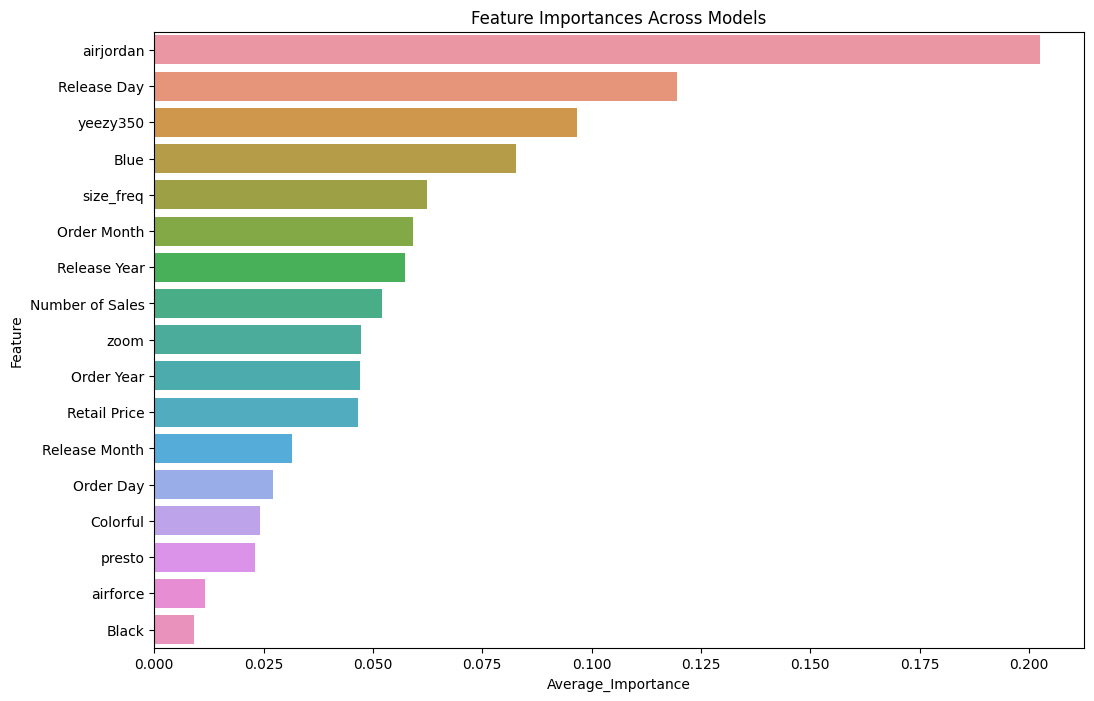

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting feature importances
plt.figure(figsize=(12, 8))
sns.barplot(data=df_importances.sort_values('Average_Importance', ascending=False), x='Average_Importance', y='Feature')
plt.title('Feature Importances Across Models')
plt.show()


In [ ]:
# Predictions from the Random Forest Regressor
y_preds_rf = model_rf.predict(X_test)  # This will be a 1D array of predicted values

# Similarly, for your other regression models:
y_preds_xgb = model_xgb.predict(X_test)  # This will be a 1D array of predicted values
y_preds_lgbm = model_lgbm.predict(X_test)  # This will be a 1D array of predicted values


In [ ]:
# Averaging predictions from different models for ensemble predictions
ensemble_preds = (y_preds_rf + y_preds_xgb + y_preds_lgbm) / 3


In [ ]:
import pandas as pd
import numpy as np

features = X_train.columns  # Column names of your features
df_importances = pd.DataFrame({
    'Feature': features,
    'Importance_RF': importances_rf,
    'Importance_XGB': importances_xgb,
    'Importance_LGBM': importances_lgbm
})

# Calculate average importance across all models (optional)
df_importances['Average_Importance'] = df_importances[['Importance_RF', 'Importance_XGB', 'Importance_LGBM']].mean(axis=1)


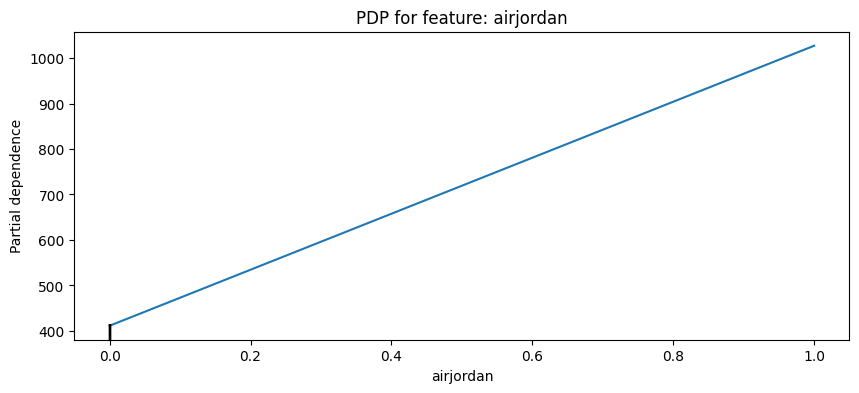

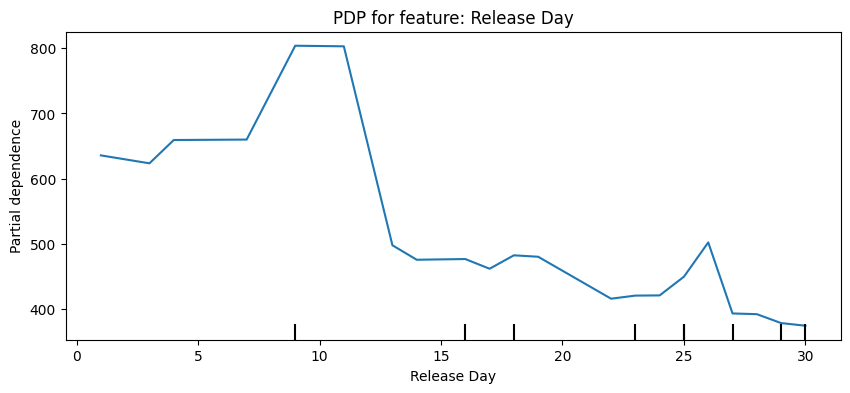

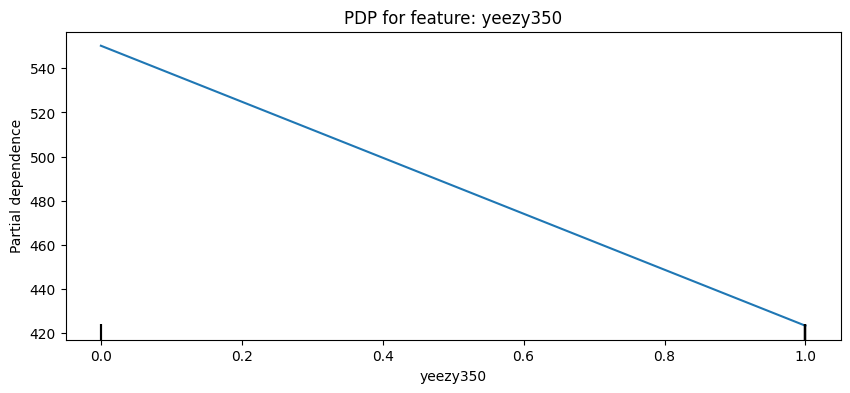

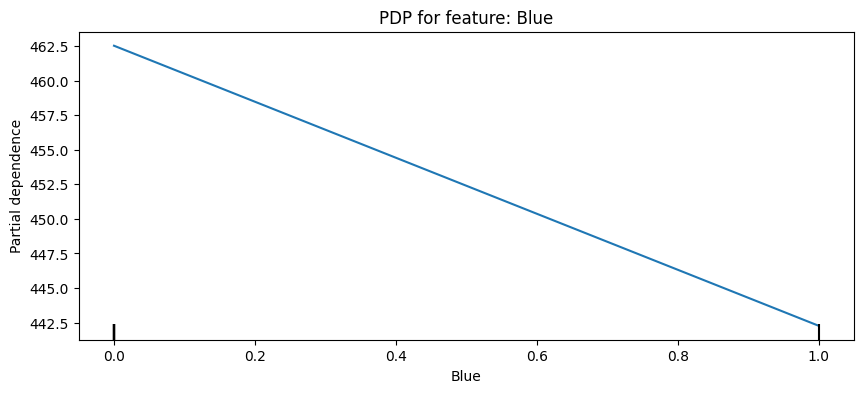

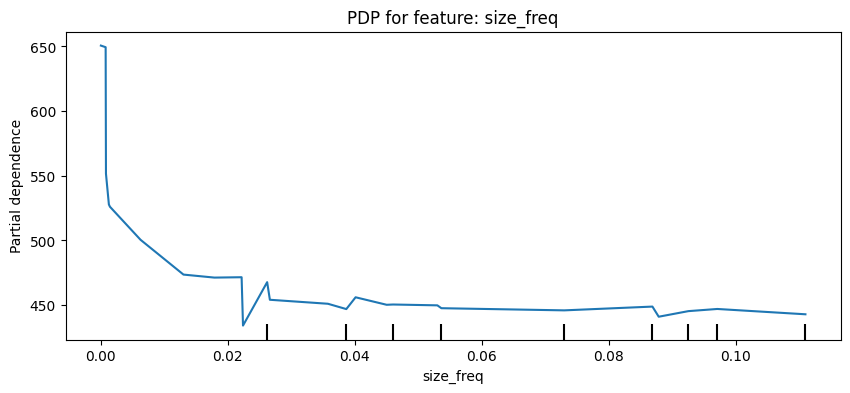

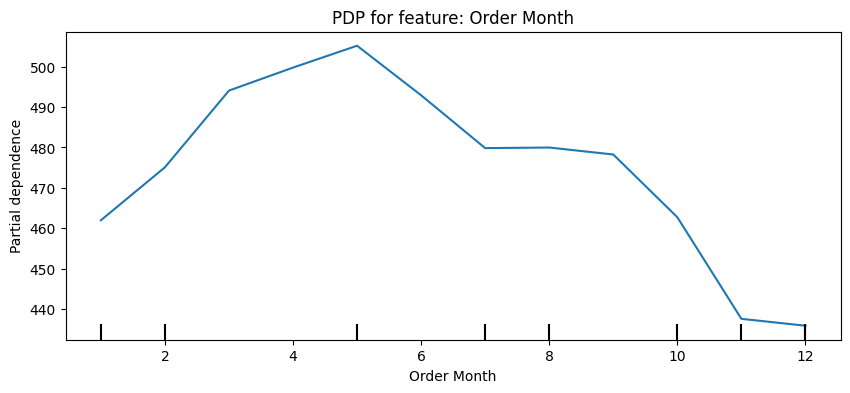

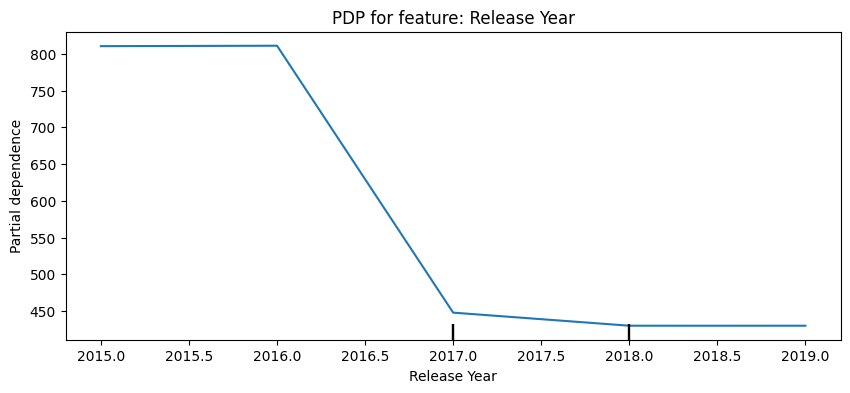

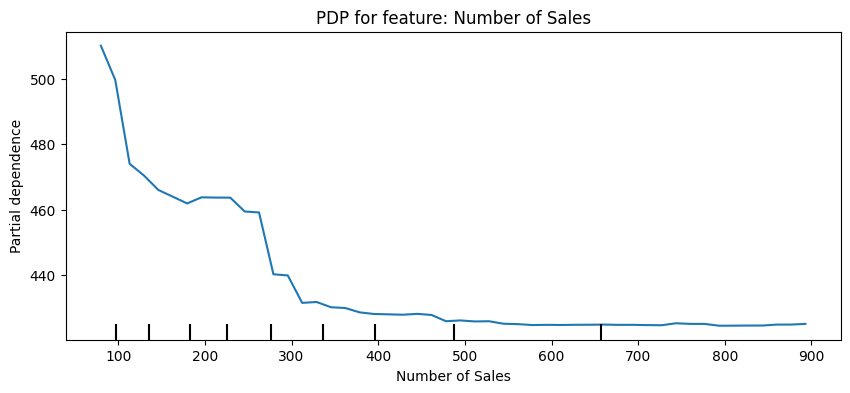

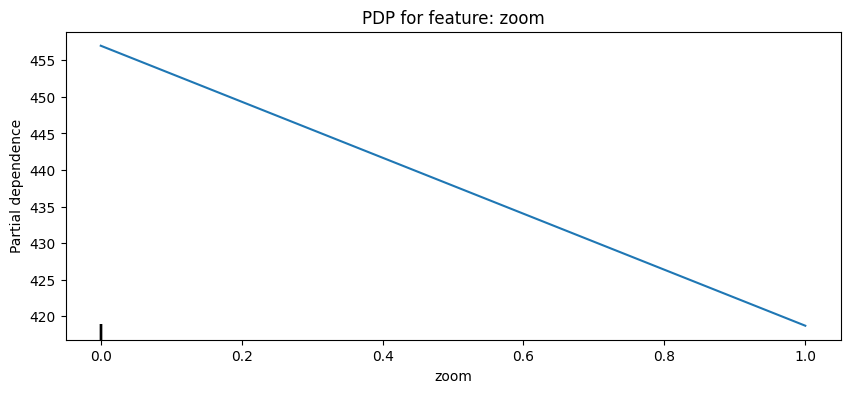

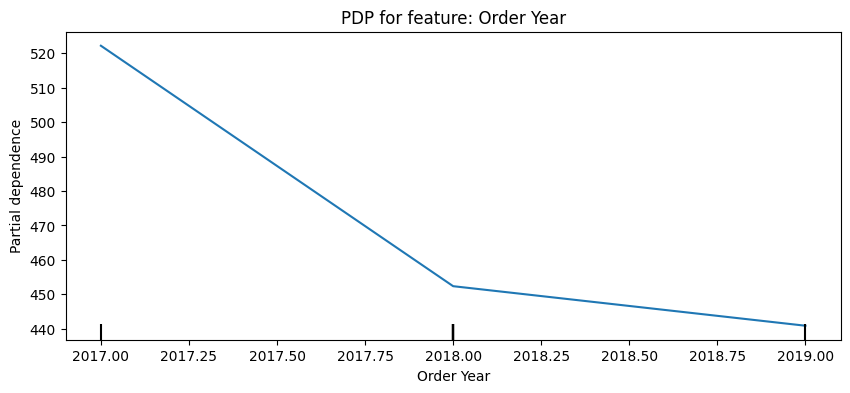

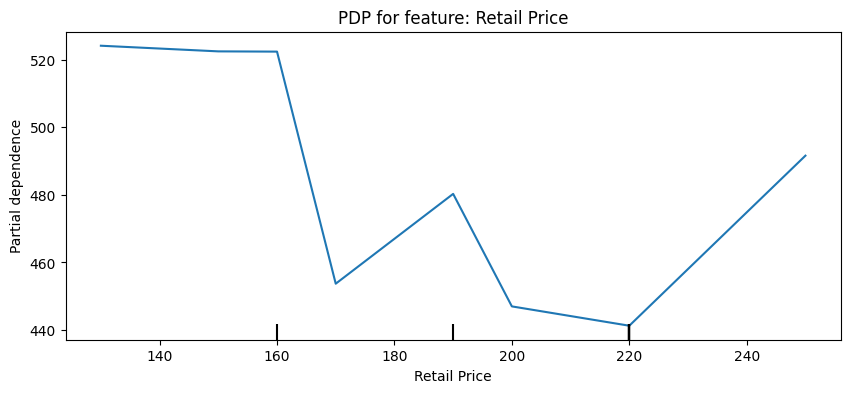

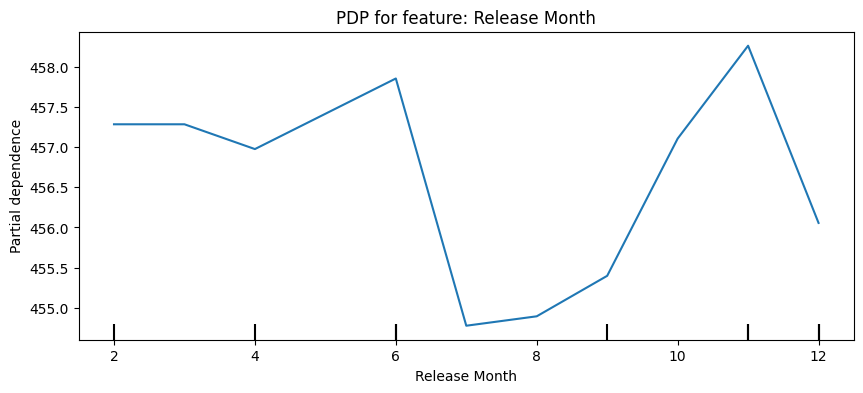

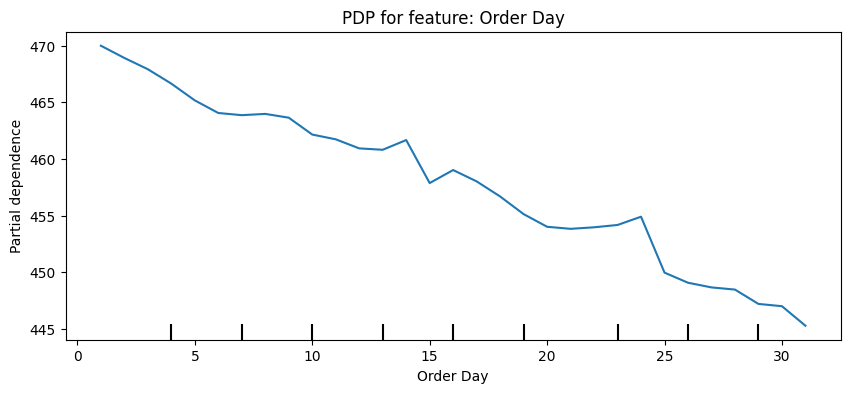

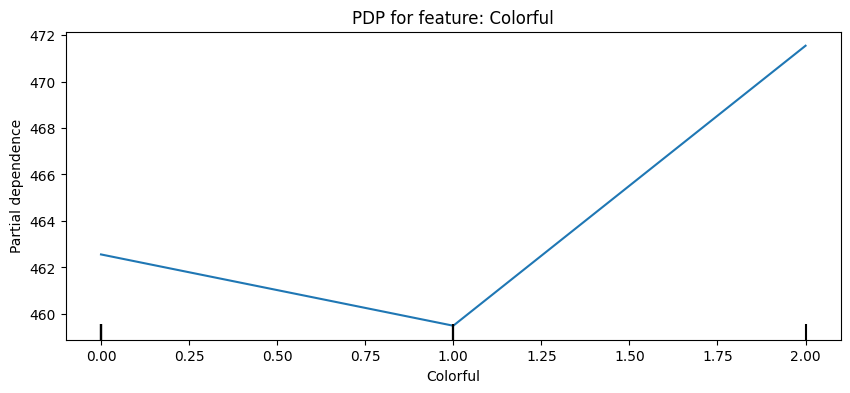

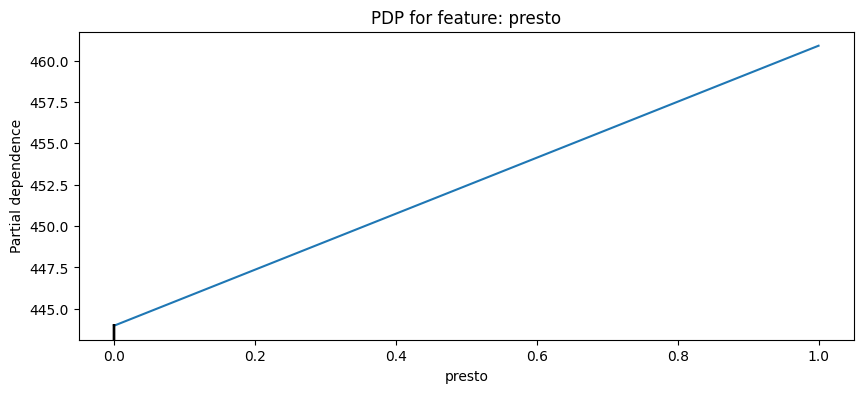

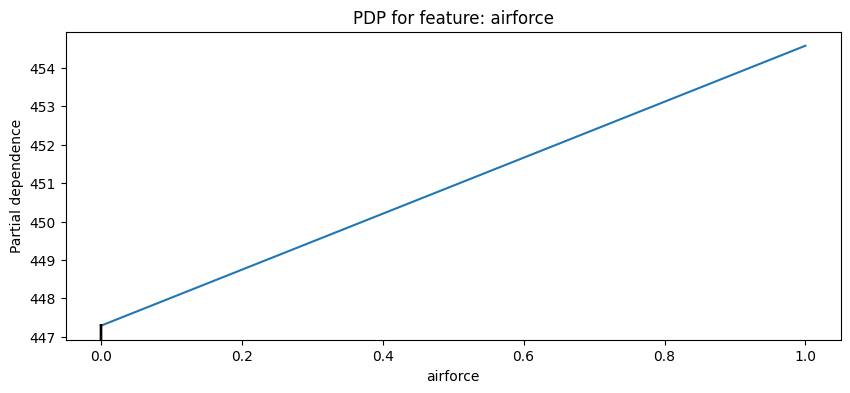

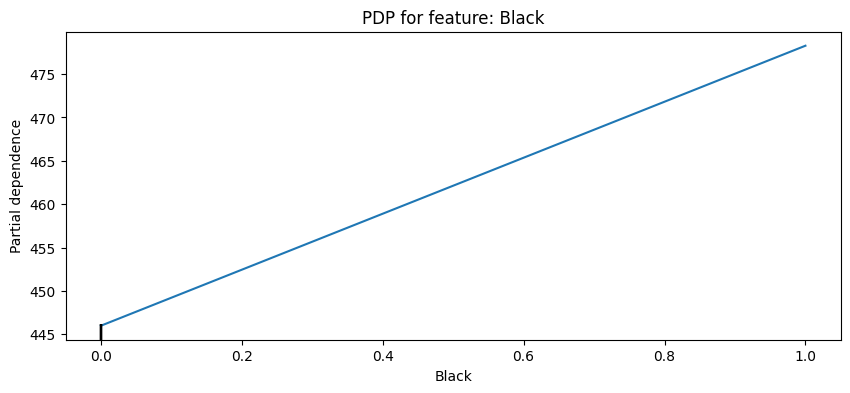

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Assuming 'model_rf' is your trained Random Forest Regressor
# and 'X_train' is the DataFrame containing your training data

# List of features for which we want to plot PDPs
features_to_plot = df_importances.sort_values('Average_Importance', ascending=False)['Feature'].tolist()

# Creating PDPs for all these features
for feature_name in features_to_plot:
    feature_index = X_train.columns.tolist().index(feature_name)

    # Plot the partial dependence plot for the feature
    fig, ax = plt.subplots(figsize=(10, 4))
    display = PartialDependenceDisplay.from_estimator(
        model_rf,
        X_train,
        features=[feature_index],
        ax=ax,
        grid_resolution=50
    )

    # Customizing the plot title
    ax.set_title(f'PDP for feature: {feature_name}')

    # Show plot
    plt.show()


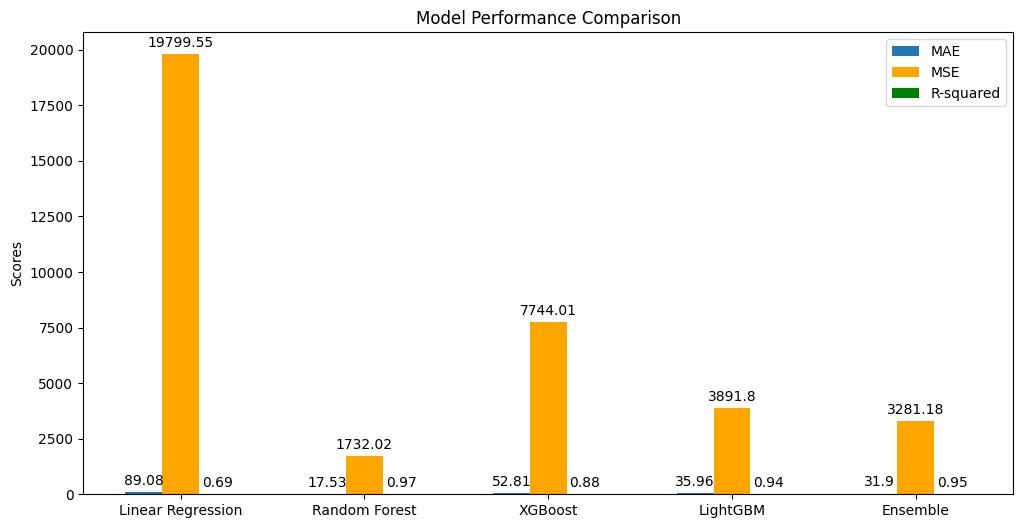

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the performance metrics for each model
models = ['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'Ensemble']
mae = [89.08, 17.53, 52.81, 35.96, 31.90]
mse = [19799.55, 1732.02, 7744.01, 3891.80, 3281.18]
r2 = [0.69, 0.9732, 0.88, 0.94, 0.95]

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, mae, width, label='MAE')
rects2 = ax.bar(x, mse, width, label='MSE', color='orange')
rects3 = ax.bar(x + width, r2, width, label='R-squared', color='green')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Attach a text label above each bar in *rects*, displaying its height.
for rects in [rects1, rects2, rects3]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.show()


In [ ]:
import pandas as pd

# Create a DataFrame to hold the metrics
metrics_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'Ensemble'],
    'MAE': [89.08, 17.53, 52.81, 35.96, 31.90],
    'MSE': [19799.55, 1732.02, 7744.01, 3891.80, 3281.18],
    'R-squared': [0.69, 0.9732, 0.88, 0.94, 0.95],
    'MAE CV': [96.04, 64.26 , 51.63, 66.04 , 20.25]
})

# Style the DataFrame for display
styled_df = metrics_df.style.background_gradient(cmap='coolwarm')
styled_df


,Model,MAE,MSE,R-squared,MAE CV
0,Linear Regression,89.080000,19799.550000,0.690000,96.040000
1,Random Forest,17.530000,1732.020000,0.973200,64.260000
2,XGBoost,52.810000,7744.010000,0.880000,51.630000
3,LightGBM,35.960000,3891.800000,0.940000,66.040000
4,Ensemble,31.900000,3281.180000,0.950000,20.250000
